## Wizeline DE Coding Challenge

As stated on this project's README, the objective of this notebook is to perform an exploratory analysis on the PROFECO dataset, a 20Gb csv file. The questions to answer are:
- How many commercial chains are monitored, and therefore, included in this database?
- What are the top 10 monitored products by State?
- Which is the commercial chain with the highest number of monitored products?
- Use the data to find an interesting fact.
- What are the lessons learned from this exercise?
- Can you identify other ways to approach this problem? Explain.

### Explore the subset

The project provides a sample subset of the original dataset. We are going to be working with it first in order to test the functions and perform an initial exploratory analysis on the subset. If everything goes fine, I'll test on the main dataset.

In [1]:
# Imports
import pandas as pd

In [2]:
sample = pd.read_csv("data/sample.csv")
sample.shape

(1999, 15)

In [3]:
sample.head()

,producto,presentacion,marca,categoria,catalogo,precio,fechaRegistro,cadenaComercial,giro,nombreComercial,direccion,estado,municipio,latitud,longitud
0,CUADERNO FORMA ITALIANA,96 HOJAS PASTA DURA. CUADRICULA CHICA,ESTRELLA,MATERIAL ESCOLAR,UTILES ESCOLARES,25.9,2011-05-18 00:00:00.000,ABASTECEDORA LUMEN,PAPELERIAS,ABASTECEDORA LUMEN SUCURSAL VILLA COAPA,CANNES No. 6 ESQ. CANAL DE MIRAMONTES,DISTRITO FEDERAL,TLALPAN,19.29699,-99.125417
1,CRAYONES,CAJA 12 CERAS. JUMBO. C.B. 201423,CRAYOLA,MATERIAL ESCOLAR,UTILES ESCOLARES,27.5,2011-05-18 00:00:00.000,ABASTECEDORA LUMEN,PAPELERIAS,ABASTECEDORA LUMEN SUCURSAL VILLA COAPA,CANNES No. 6 ESQ. CANAL DE MIRAMONTES,DISTRITO FEDERAL,TLALPAN,19.29699,-99.125417
2,CRAYONES,CAJA 12 CERAS. TAMANO REGULAR C.B. 201034,CRAYOLA,MATERIAL ESCOLAR,UTILES ESCOLARES,13.9,2011-05-18 00:00:00.000,ABASTECEDORA LUMEN,PAPELERIAS,ABASTECEDORA LUMEN SUCURSAL VILLA COAPA,CANNES No. 6 ESQ. CANAL DE MIRAMONTES,DISTRITO FEDERAL,TLALPAN,19.29699,-99.125417
3,COLORES DE MADERA,CAJA 12 PIEZAS LARGO. TRIANGULAR. C.B. 640646,PINCELIN,MATERIAL ESCOLAR,UTILES ESCOLARES,46.9,2011-05-18 00:00:00.000,ABASTECEDORA LUMEN,PAPELERIAS,ABASTECEDORA LUMEN SUCURSAL VILLA COAPA,CANNES No. 6 ESQ. CANAL DE MIRAMONTES,DISTRITO FEDERAL,TLALPAN,19.29699,-99.125417
4,COLOR LARGO,CAJA 36 PIEZAS. CON SACAPUNTAS. 68-4036,CRAYOLA,MATERIAL ESCOLAR,UTILES ESCOLARES,115.0,2011-05-18 00:00:00.000,ABASTECEDORA LUMEN,PAPELERIAS,ABASTECEDORA LUMEN SUCURSAL VILLA COAPA,CANNES No. 6 ESQ. CANAL DE MIRAMONTES,DISTRITO FEDERAL,TLALPAN,19.29699,-99.125417


Since the big dataset will be processed in chunks, I'm going to parse through the sample dataset with chunks as well, so I'm redefining it. But now I know that the shape should add to (1999, 15).

In [4]:
sample = pd.read_csv("data/sample.csv", chunksize=200) # This should give me 10 chunks
for i, chunk in enumerate(sample):
    print(i, chunk.shape)
sample = pd.read_csv("data/sample.csv", chunksize=200) # Redifining because this is an iterable.

0 (200, 15)
1 (200, 15)
2 (200, 15)
3 (200, 15)
4 (200, 15)
5 (200, 15)
6 (200, 15)
7 (200, 15)
8 (200, 15)
9 (199, 15)


#### Designing the functions

My idea is to process the analysis questions on each chunk and add the answer on an aggregation DataFrame, so that I can easily calculate the general answer once I process the whole dataset. So now I'm going to create some helper functions that will calculate each analytical question.

##### Question 1: Number of commercial chains

The following function aggregates the unique set of commercial chains per chunk. This allows us to get the final aggregated total commercial chains at the end.

In [5]:
def n_commercial_chains(chunk: pd.DataFrame, answer: pd.DataFrame, col_name="cadenaComercial"):
    """
        This function will calculate the number of commercial chains on the dataset.
        It will query the chunk and add the commercial chains.
        :param chunk: The incoming chunk we are going to process.
        :param answer: The resulting answer DataFrame.
        :param col_name: Name of the column on the csv.
    """
    chains = pd.DataFrame(chunk[col_name].unique(), columns=[col_name]) # Get the unique chains on the chunk
    return answer.append(chains)

In [6]:
answer = pd.DataFrame(columns=['cadenaComercial'])
# Iterate through the chunks and extract the unique chains per chunk
for chunk in sample:
    answer = n_commercial_chains(chunk=chunk, answer=answer)
answer.head()

,cadenaComercial
0,ABASTECEDORA LUMEN
1,COMERCIAL MEXICANA
0,COMERCIAL MEXICANA
0,COMERCIAL MEXICANA
0,COMERCIAL MEXICANA


In [7]:
# We extract the unique values on the resulting df. The shape will give us the number of unique chains.
answer = pd.DataFrame(answer["cadenaComercial"].unique(), columns=["cadenaComercial"])
unique_chains = answer.shape[0]
print(unique_chains)
answer

4


,cadenaComercial
0,ABASTECEDORA LUMEN
1,COMERCIAL MEXICANA
2,I.S.S.S.T.E.
3,WAL-MART


##### Question 2: Top 10 products by state

This code will create a helper column "count" on each chunk. Then we use panda's function groupby to create a custom grouping on 2D: products and states. The results of each grouping are added and then appended into the final dataframe. This final dataframe is finally grouped again and we extract the top 10 products with the helper function bellow.

In [8]:
def products_by_state(chunk: pd.DataFrame, answer: pd.DataFrame, 
                             product_col="producto", state_col="estado"):
    """
        This function will get the aggregated count of products by state. This will result on a df where we will
        later on compute the top 10 products.
        :param chunk: The incoming chunk we are going to process.
        :param answer: The resulting answer DataFrame.
        :param product_col: Name of the column on the csv.
        :param state_col: Name of the column on the csv.
    """
    chunk["count"] = 1
    group = chunk.groupby([state_col, product_col], as_index=False)["count"].sum()
    answer = pd.concat([answer, group])
    return answer

In [9]:
sample = pd.read_csv("data/sample.csv", chunksize=200) # Redifining because this is an iterable.
answer = pd.DataFrame()
for chunk in sample:
    answer = products_by_state(chunk, answer)

In [10]:
final = pd.DataFrame(answer.groupby(["estado", "producto"], as_index=False)["count"].sum()).sort_values(by=["estado", "count"], ascending=False)
final.head()

,estado,producto,count
491,MÉXICO,REFRESCO,26
354,MÉXICO,DETERGENTE P/ROPA,24
508,MÉXICO,SHAMPOO,19
331,MÉXICO,CHILES EN LATA,18
422,MÉXICO,LECHE ULTRAPASTEURIZADA,17


In [11]:
def top_10_products_by_state(state, df):
    """
        Returns the top 10 prods by state.
        Assumes df is already procesed.
        :param state: The name of the state
        :param df: The df
    """
    return df.loc[df["estado"]==state][:10]

In [12]:
top_10_products_by_state("MÉXICO", final).head()

,estado,producto,count
491,MÉXICO,REFRESCO,26
354,MÉXICO,DETERGENTE P/ROPA,24
508,MÉXICO,SHAMPOO,19
331,MÉXICO,CHILES EN LATA,18
422,MÉXICO,LECHE ULTRAPASTEURIZADA,17


##### Question 3: Chain with most products.

This piece of code, similarly to the previous ones, performs a grouping per chunk and then appends the result to a final dataframe. The main difference is that in here we are grouping on one dimension "chain" instead of two.

In [13]:
def chain_w_most_products(chunk: pd.DataFrame, answer: pd.DataFrame, chain_col="cadenaComercial"):
    """
        This function will get the count of products per chain per chunk.
        :param chunk: The incoming chunk we are going to process.
        :param answer: The resulting answer DataFrame.
        :param chain_col: Name of the column on the csv.
    """
    chunk["count"] = 1
    group = chunk.groupby([chain_col], as_index=False)["count"].sum()
    answer = pd.concat([answer, group])
    return answer

In [14]:
sample = pd.read_csv("data/sample.csv", chunksize=200) # Redifining because this is an iterable.
answer = pd.DataFrame()
for chunk in sample:
    answer = chain_w_most_products(chunk, answer)
answer = pd.DataFrame(answer.groupby(["cadenaComercial"], as_index=False)["count"].sum()).sort_values(by=["count"], ascending=False)
answer.head()

,cadenaComercial,count
1,COMERCIAL MEXICANA,1508
3,WAL-MART,287
2,I.S.S.S.T.E.,195
0,ABASTECEDORA LUMEN,9


##### Question 4: An interesting fact

I decided to get the number of products sold by state so that, in the future, I can plot a map possibly with Plotly's choropleth functionalities, where the strongest color will be for the states with the most products sold.
Due to the lack of time, I will only calculate the dataframe.

In [15]:
def interesting_fact(df: pd.DataFrame, answer: pd.DataFrame, state_col="estado"):
    """
        This function will get the interesting fact. I want to get the counts with 
        the states that sell more products.
        :param df:  This method expects the result df from question 2.
        :param answer: The resulting answer DataFrame.
        :param chain_col: Name of the column on the csv.
    """
    group = df.groupby([state_col], as_index=False)["count"].sum()
    answer = answer.append(group)
    return answer

In [16]:
answer = pd.DataFrame()
interesting = interesting_fact(final, answer)
interesting

,estado,count
0,DISTRITO FEDERAL,942
1,MÉXICO,1057


##### Main function

This method will execute all the functions coded above and store them in their corresponding answer dataframes. This way we ensure that we only run over the original dataset only once.

In [17]:
import time
def execute_all(main_df: pd.DataFrame):
    """
        This function will execute the 4 queries while iterating through the chunks.
    """
    start = time.time()
    answer_1 = pd.DataFrame(columns=["cadenaComercial"])
    answer_2 = pd.DataFrame()
    final_2 = pd.DataFrame()
    final_ans_2 = pd.DataFrame()
    answer_3 = pd.DataFrame()
    answer_4 = pd.DataFrame()
    # Iterate through the chunks and extract the unique chains per chunk
    for i, chunk in enumerate(main_df):
        # Question 1
        answer_1 = n_commercial_chains(chunk=chunk, answer=answer_1)
        answer_1 = pd.DataFrame(answer_1["cadenaComercial"].unique(), columns=["cadenaComercial"])
        unique_chains = answer_1.shape[0]
        # Question 2
        answer_2 = products_by_state(chunk=chunk, answer=answer_2)
        final_2 = pd.DataFrame(answer_2.groupby(["estado", "producto"], as_index=False)["count"].sum()).sort_values(by=["estado", "count"], ascending=False)
        # Question 3
        answer_3 = chain_w_most_products(chunk=chunk, answer=answer_3)
        answer_3 = pd.DataFrame(answer_3.groupby(["cadenaComercial"], as_index=False)["count"].sum()).sort_values(by=["count"], ascending=False)
        if i % 10000000 == 0:
            print(i, time.time()-start)
    # Question 4
    answer_4 = interesting_fact(final_2, answer_4)
    for state in final_2["estado"].unique():
        final_ans_2 = final_ans_2.append(top_10_products_by_state(state, final_2))
    print(time.time() - start, "total seconds of execution.")
    return answer_1, final_ans_2, answer_3, answer_4

In [18]:
sample = pd.read_csv("data/sample.csv", chunksize=200) # Redifining because this is an iterable.
a1, a2, a3, a4 = execute_all(main_df=sample)

0 0.018651723861694336
0.1742110252380371 total seconds of execution.


In [19]:
a1.shape

(4, 1)

In [20]:
a2.head()

,estado,producto,count
491,MÉXICO,REFRESCO,26
354,MÉXICO,DETERGENTE P/ROPA,24
508,MÉXICO,SHAMPOO,19
331,MÉXICO,CHILES EN LATA,18
422,MÉXICO,LECHE ULTRAPASTEURIZADA,17


In [21]:
a3.head()

,cadenaComercial,count
1,COMERCIAL MEXICANA,1508
3,WAL-MART,287
2,I.S.S.S.T.E.,195
0,ABASTECEDORA LUMEN,9


In [22]:
a4.head()

,estado,count
0,DISTRITO FEDERAL,942
1,MÉXICO,1057


### Run on the main dataset

I'm going to run the code with 1 million as my chunk size. Pandas is based on numpy so I'm pretty confident my memory will be able to efficiently hold this data without breaking. However it is still necessary to set the low_memory parameter to False.

In [23]:
maindf = pd.read_csv("../../Downloads/profeco.zip", 
                     chunksize=1000000, compression="zip", low_memory=False)
a1, a2, a3, a4 = execute_all(main_df=maindf)

0 4.410244941711426
245.44243001937866 total seconds of execution.


#### Question 1 Answer:

The a1 df holds the aggregation of all the unique chains on the dataset.

In [24]:
print("Shape:", a1.shape)
a1.head()

Shape: (706, 1)


,cadenaComercial
0,ABASTECEDORA LUMEN
1,COMERCIAL MEXICANA
2,I.S.S.S.T.E.
3,WAL-MART
4,TORTILLERIAS TRADICIONALES


Is the same as:

In [25]:
a1['cadenaComercial'].unique().shape

(706,)

#### Question 2 Answer:

The top 10 products per state can be checked on the a2 df. The df is stacked so let's query a couple of the results.

<AxesSubplot:xlabel='producto'>

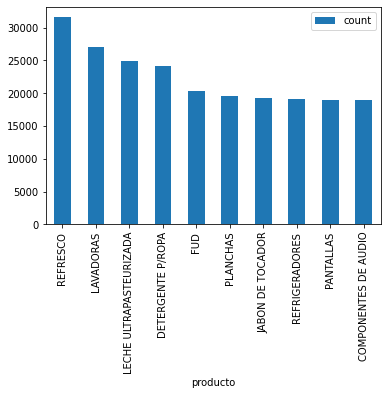

In [26]:
a2.loc[a2["estado"]=="PUEBLA"].plot.bar(x="producto", y="count")

<AxesSubplot:xlabel='producto'>

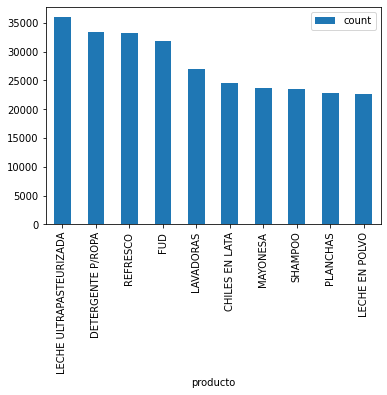

In [27]:
a2.loc[a2["estado"]=="YUCATÁN"].plot.bar(x="producto", y="count")

#### Question 3 Answer:

Similarly to the previous question, the resulting aggregated df holds the count of products per commercial chain.
We can extract the max by either sorting and extracting the first row or by using the max function.

In [34]:
a3.sort_values(by="count", ascending=False).head()

,cadenaComercial,count
683,WAL-MART,8643133
38,BODEGA AURRERA,6765453
574,SORIANA,6546211
301,MEGA COMERCIAL MEXICANA,4899509
58,CHEDRAUI,4221625


#### Question 4 Answer:

As stated before, the interesting fact I want to calculate is basically get an idea of the states that consume more products in total. This is interesting because it could be plotted into a geojson of Mexico, observing the differences between the states and how much products are offered. It could be interesting as well to compare against the real population in those states and see if there is any correlation between the number of products offered vs the number of citizens per state.

In [29]:
a4.sort_values(by="count", ascending=False).head()

,estado,count
8,DISTRITO FEDERAL,11284102
16,MÉXICO,8173302
13,JALISCO,4552128
18,NUEVO LEÓN,3171091
10,GUANAJUATO,2638456


#### Lessons Learned

Pandas is such a powerful tool it always surprises me. The main lesson I have learnt is that when parsing a huge dataset such as this one it is often a good idea to have a plan, and if possible, code the analysis in such a way that you can cover as many answers as possible with only one iteration. Oftentimes this makes the difference between a code that takes some minutes against a code that takes hours.  

Also, I enjoyed working with a ziped csv, I haven't done that before but it's a great tool provided by pandas.

#### Other approaches

I think that performing an analysis on this dataset could be possible since it is semi structured, however I would suggest performing an ETL job into a database specifically designed for analysis like Cassandra or Redshift, and reestructure the schema into a star o snowflake schema if possible.

The idea that comes to my mind is to first design a fact/dimension schema for Redshift, populate it with the csv, and structure it in such a way that each data cluster is leveraged. For example, by creating a distribution key of (state, product) for the second query. This would enhance the processing time when querying, even though it would slow down the writing time.